<a href="https://colab.research.google.com/github/nadaz10/Neural-Machine-Translation/blob/main/Neural_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for Programming in Problem 4
Welcome to the programming portion of the assignment! Each assignment throughout the semester will have a written portion and a programming portion. We will be using [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true), so if you have never used it before, take a quick look through this introduction: [Working with Google Colab](https://docs.google.com/document/d/1LlnXoOblXwW3YX-0yG_5seTXJsb3kRdMMRYqs8Qqum4/edit?usp=sharing).

Learning Objectives
In this problem, we will use [PyTorch](https://pytorch.org/) to implement a sequence-to-sequence (seq2seq) transformer model to build a nerual machine translation (NMT) system, which translates from French to English.

## 1. Installing Packages and NMT data

Install PyTorch using pip. See [https://pytorch.org/](https://pytorch.org/) if you want to install it on your computer.
In addition, we will also be needing [huggingface](https://huggingface.co/)'s `transformers` and `datasets` libraries, and [nltk](https://www.nltk.org/) to compute the BLEU score.

In [ ]:
# Pytorch is typically already installed in Google Colab (uncomment to install):
# !pip install torch==1.8.0
# or for GPU support:
# !pip install torch==1.8.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install transformers==4.27.0
!pip install datasets==2.10.0
# NLTK is typically also already installed in Google Colab (uncomment to install):
# !pip install nltk==3.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.2
    Uninstalling transformers-4.40.2:
      Successfully uninstalled transformers-4.40.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━

We first download the data for NMT, which contains pairs of parallel sentences.

In [ ]:
!wget --quiet https://princeton-nlp.github.io/cos484/assignments/a4/resources.zip
!unzip -qo resources.zip

## 2. Data preprocessing


In this section, we load and preprocess the dataset that will be used for training our neural machine translation (NMT) model. The dataset consists of parallel English and French sentences, which are partitioned into training, validation, and test splits.

We use the `load_from_disk` function from the `datasets` library to load the pre-saved dataset from disk. The dataset is loaded into a `DatasetDict` object, which contains three splits:

- **Train**: Contains 8,701 pairs of English and French sentences.
- **Validation**: Contains 485 pairs of English and French sentences.
- **Test**: Contains 486 pairs of English and French sentences.

Each example in the dataset is a dictionary with two keys: `text_en` for the English sentence and `text_fr` for the French sentence.

To get a better understanding of the data, we display a few examples from each split. This helps us verify the content and structure of the dataset before proceeding with further preprocessing steps.

Below is the summary of the dataset splits and a few examples from each split.


In [ ]:
from datasets import load_from_disk
raw_text_datasets = load_from_disk("resources/parallel_en_fr_corpus")

# Print summary of splits
print("Summary of splits:", raw_text_datasets)

# Display a few examples from each split
for split in ["train", "validation", "test"]:
    print(f"\nFirst 3 examples from the {split} split:")
    for i in range(3):
        example = raw_text_datasets[split][i]
        print(f"Example {i+1}: English: {example['text_en']} - French: {example['text_fr']}")


Summary of splits: DatasetDict({
    train: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 8701
    })
    validation: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 485
    })
    test: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 486
    })
})

First 3 examples from the train split:
Example 1: English: i m tough . - French: je suis dure .
Example 2: English: i m not in a rush . - French: je ne suis pas aux pieces .
Example 3: English: i m not sleeping well . - French: je ne dors pas bien .

First 3 examples from the validation split:
Example 1: English: she is a most gracious neighbor . - French: c est une voisine des plus courtoises .
Example 2: English: i m not sitting here . - French: je ne vais pas m asseoir ici .
Example 3: English: you re not wanted here . - French: on ne veut pas de toi ici .

First 3 examples from the test split:
Example 1: English: i m trustworthy . - French: on peut me faire confiance .


### 2.1 Tokenisation

You are also provided with two pre-trained tokenizers for the source and target languages respectively, which we can load with the hugginface transfomers library. [This tutorial](https://huggingface.co/docs/transformers/preprocessing#natural-language-processing) provides an introduction to using pre-trained tokenizers and the powerful `AutoTokenizer` class. The tokenizers are based on byte-pair encodings which break words into smaller units. This is aimed at reducing the sparsity of words, as subwords can be shared between different rare words. If you are interested in learning more, see the paper [Neural Machine Translation of Rare Words with Subword Units](https://www.aclweb.org/anthology/P16-1162.pdf).

#### What is Tokenization?

Tokenization is the process of converting raw text into smaller units called tokens. Tokens can be words, subwords, or even characters. This process is essential in natural language processing (NLP) as it transforms text data into a numerical format that machine learning models can process.

#### Why is Tokenization Important?

In the context of neural machine translation (NMT), tokenization is crucial for several reasons:

1. **Handling Vocabulary Size**: Directly working with whole words would result in a very large vocabulary, making the model less efficient and harder to train. By breaking words into subwords, we can significantly reduce the vocabulary size.
2. **Dealing with Rare Words**: Tokenizing into subwords allows the model to handle rare words more effectively. Even if a word is not seen during training, its subwords might be, enabling the model to understand and translate it.
3. **Model Compatibility**: Machine learning models require numerical input. Tokenization converts text into numerical IDs that the model can process.

#### Example of Tokenization

Let's consider the English sentence: "we have an example".

The tokenizer converts this sentence into the following tokens:
- `<s>`: Start of sentence token.
- `▁we`: The word "we" with a special character indicating the start of a new word.
- `▁have`: The word "have" with the start of a new word indicator.
- `▁an`: The word "an" with the start of a new word indicator.
- `▁ex`: The beginning of the word "example".
- `amp`: The middle part of the word "example".
- `le`: The end part of the word "example".
- `</s>`: End of sentence token.

The output tokens are:
```
['<s>', '▁we', '▁have', '▁an', '▁ex', 'amp', 'le', '</s>']
```

These tokens are then converted into numerical IDs that the model can process:
```
{'input_ids': [1, 64, 324, 103, 266, 1490, 92, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
```

Here:
- `input_ids` are the numerical representations of the tokens.
- `token_type_ids` are used to differentiate between different types of sequences (not relevant here as we have a single sentence).
- `attention_mask` indicates which tokens should be attended to (1 for real tokens, 0 for padding).


In [ ]:
from transformers import AutoTokenizer

# Load the pre-trained tokenizers for French and English
source_tokenizer = AutoTokenizer.from_pretrained("resources/tokenizer_fr")
target_tokenizer = AutoTokenizer.from_pretrained("resources/tokenizer_en")

# Display the vocabulary sizes of both tokenizers
print("Vocab size of source language (French):", source_tokenizer.vocab_size)
print("Vocab size of target language (English):", target_tokenizer.vocab_size)

# Define an example sentence in English
example_sentence = "we have an example"

# Tokenize the example sentence using the target (English) tokenizer
tokenizer_output = target_tokenizer(example_sentence)

# Display the original example sentence
print("\n*** Example Sentence ***")
print("Example sentence:", example_sentence)

# Display the tokenizer output in a more detailed manner
print("\n*** Tokenizer Output ***")
print("Token IDs:", tokenizer_output["input_ids"])
print("Token Type IDs:", tokenizer_output["token_type_ids"])
print("Attention Mask:", tokenizer_output["attention_mask"])

# Convert the token IDs back to their corresponding tokens
tokens = [target_tokenizer.decode(token) for token in tokenizer_output["input_ids"]]
print("\n*** Tokens ***")
print("Tokens:", tokens)

# Reconstruct the sentence from the tokens, replacing the special character '▁' with a whitespace
reconstructed_sentence = "".join(tokens).replace("▁", " ")
print("\n*** Reconstructed Sentence ***")
print("Reconstructed sentence:", reconstructed_sentence)


Vocab size of source language (French): 3200
Vocab size of target language (English): 3200

*** Example Sentence ***
Example sentence: we have an example

*** Tokenizer Output ***
Token IDs: [1, 64, 324, 103, 266, 1490, 92, 2]
Token Type IDs: [0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1]

*** Tokens ***
Tokens: ['<s>', '▁we', '▁have', '▁an', '▁ex', 'amp', 'le', '</s>']

*** Reconstructed Sentence ***
Reconstructed sentence: <s> we have an example</s>


### 2.3 Mapping

We now want to convert the entire dataset to token ids.
Specifically, we want to use the tokenizers to create a dataset with
features "encoder_input_ids" and "decoder_input_ids", which both have type `List[int]`
and which will later be the inputs to our encoder-decoder model. We will implement this using the powerful `map` function. You can find its API reference [here](https://huggingface.co/docs/datasets/v2.10.0/en/package_reference/main_classes#datasets.Dataset.map).

In [ ]:
from typing import Dict, List

def map_example(example: Dict[str, str]) -> Dict[str, List[int]]:
    # TODO: Tokenize the source and target text for an entry in the parallel dataset
    # and return a dictionary with the keys "encoder_input_ids" and "decoder_input_ids".
    # You can use `source_tokenizer` and `target_tokenizer`
    # Print example to understand its structure
    #print(example)

    # Assuming the keys are 'text_en' for English and 'text_fr' for French
    source_text = example["text_fr"]
    target_text = example["text_en"]

    # Tokenize the source text (French)
    source_encoded = source_tokenizer(source_text, truncation=True, padding='max_length') #trial:, max_length=128
    # Tokenize the target text (English)
    target_encoded = target_tokenizer(target_text, truncation=True, padding='max_length')

    return {
        "encoder_input_ids": source_encoded['input_ids'],
        "decoder_input_ids": target_encoded['input_ids']
    }

# When mapped is applied to the DatasetDict object, it will apply `map` separately to each split.
tokenized_datasets = raw_text_datasets.map(map_example, batched=False)

# The `remove_columns` removes the existing text features from the new dataset, as they are no longer needed.
tokenized_datasets = tokenized_datasets.remove_columns(raw_text_datasets.column_names["train"])

# Sanity checks on the new dataset
assert set(tokenized_datasets.column_names["train"]) == {"decoder_input_ids", "encoder_input_ids"}
assert len(tokenized_datasets["train"]) == len(raw_text_datasets["train"])
# Print a few examples to visualize and do a sanity check
for i in range(3):
    example = tokenized_datasets["train"][i]
    print(f"Example {i}:")
    print(f"Encoder input IDs: {example['encoder_input_ids']}")
    print(f"Decoder input IDs: {example['decoder_input_ids']}")
    print("Source text (decoded):", source_tokenizer.decode(example['encoder_input_ids'], skip_special_tokens=True))
    print("Target text (decoded):", target_tokenizer.decode(example['decoder_input_ids'], skip_special_tokens=True))
    print()

Map:   0%|          | 0/8701 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/486 [00:00<?, ? examples/s]

Example 0:
Encoder input IDs: [1, 47, 60, 1449, 36, 2]
Decoder input IDs: [1, 37, 42, 1044, 35, 2]
Source text (decoded): ▁je ▁suis ▁dure ▁.
Target text (decoded): ▁i ▁m ▁tough ▁.

Example 1:
Encoder input IDs: [1, 47, 86, 60, 68, 531, 1037, 385, 36, 2]
Decoder input IDs: [1, 37, 42, 60, 89, 39, 259, 2914, 35, 2]
Source text (decoded): ▁je ▁ne ▁suis ▁pas ▁aux ▁pie ces ▁.
Target text (decoded): ▁i ▁m ▁not ▁in ▁a ▁r ush ▁.

Example 2:
Encoder input IDs: [1, 47, 86, 48, 883, 68, 239, 36, 2]
Decoder input IDs: [1, 37, 42, 60, 1678, 501, 35, 2]
Source text (decoded): ▁je ▁ne ▁d ors ▁pas ▁bien ▁.
Target text (decoded): ▁i ▁m ▁not ▁sleeping ▁well ▁.



In [ ]:
 #Example dataset as before
example_dataset = [
    {"text_en": "we have an example", "text_fr": "nous avons un exemple"}
]
mapped_example = map_example(example_dataset[0])

print("Mapped example:", mapped_example)

Mapped example: {'encoder_input_ids': [1, 79, 349, 82, 298, 13, 130, 52, 2], 'decoder_input_ids': [1, 64, 324, 103, 266, 1490, 92, 2]}


## Transformer model for NMT

We will now implement a encoder-decoder transformer model.
We already provide code for the Feedforward Layers and Transformer Blocks, but you will have to implement the MultiHeadAttention and Embedding layer from scratch, as well as registering all the layers in the final EncoderDecoderModel. Pay attention to doc-strings and typing information to understand the context and purpose of each missing code block!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
from typing import Optional, Dict, List, Tuple

Multihead Attention is basically a dot product and scaling


#### Implementing a Multi-Head Attention Layer for NMT

In this section, we will implement a multi-head attention (MHA) layer, which is a critical component of the transformer model used in neural machine translation (NMT). The MHA layer allows the model to focus on different parts of the input sequence for each position in the output sequence. Here's a detailed explanation of the implementation steps:

#### Multi-Head Attention Class

1. **Initialization:**
   - The `MultiHeadAttention` class initializes the necessary components for the attention mechanism. It takes the `hidden_size`, `num_attention_heads`, and flags for causal and cross-attention as inputs.
   - The hidden size is divided by the number of attention heads to get the dimension of each head.
   - Query, key, and value projections are defined using linear layers. These projections transform the input vectors into query, key, and value vectors used for computing attention.
   - An output projection is also defined to transform the concatenated attention outputs back to the original hidden size.

2. **Causal Attention Mask:**
   - The `causal_attention_mask` method creates a mask that prevents attending to future tokens in the sequence. This is important for autoregressive models where the prediction for each token should not depend on future tokens.
   - The mask is a triangular matrix with large negative values above the diagonal, ensuring that positions can only attend to themselves and previous positions.

3. **Forward Method:**
   - **Projections:**
     - If `is_cross_attention` is true, keys and values are derived from the encoder outputs, while queries come from the decoder inputs.
     - For self-attention, all projections are derived from the hidden states of the current layer.
   - **Reshaping:**
     - The query, key, and value tensors are reshaped to separate the different attention heads.
   - **Scaled Dot-Product Attention:**
     - Attention scores are computed by taking the dot product of query and key vectors, scaled by the square root of the head dimension.
   - **Masking:**
     - The key padding mask is applied to ignore padding tokens in the input.
     - If causal attention is enabled, the causal mask is added to prevent attending to future tokens.
   - **Softmax:**
     - The attention scores are normalized using the softmax function to get the attention weights.
   - **Attention Output:**
     - The attention weights are used to compute a weighted sum of the value vectors.
   - **Combining Heads:**
     - The outputs from all heads are concatenated and projected back to the original hidden size using the output projection layer.
   - The method returns the final attention output and the attention weights.

#### Example Output

Consider an example with an input batch containing the sentence "we have an example" (English) and "nous avons un exemple" (French). After tokenization, the attention layer processes these inputs:

- **Encoder Input IDs (`encoder_input_ids`):** [1, 79, 349, 82, 298, 13, 130, 52, 2]
  - These IDs represent the French sentence after tokenization, including special start (`<s>`) and end (`</s>`) tokens.
- **Decoder Input IDs (`decoder_input_ids`):** [1, 64, 324, 103, 266, 1490, 92, 2]
  - These IDs represent the English sentence after tokenization, with the same special tokens.

The attention mechanism will use these IDs to compute attention scores and aggregate the information from different parts of the input sequences. This allows the model to focus on relevant parts of the input when generating translations, making it more effective in capturing dependencies and context.



In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 num_attention_heads: int,
                 is_causal_attention: bool = False,
                 is_cross_attention: bool = False):
        """Defines a flexible multi-head attention layer.

        This layer should define parameters for the query, key and value projections, as well as the output projection,
        and implement the following steps:
        (1) Project the input vectors using query projection and key projection matrices.
        (2) Compute the head-wise attention scores scaled by 1/sqrt(head_dim)
        (3) Perform appropriate masking to the attention scores using key_padding_mask and optionally causal attention.
        (4) Normalize the head-wise attention scores using softmax.
        (5) Compute the value projections and then aggregate using the normalized attention scores.
        (6) Use the output projection to obtain the final output vectors.
        When is_cross_attention is True, the key and value projections are computed from the encoder outputs.
        Note that we do not use attention weight dropout in this implementation.

        Args:
            hidden_size: The dimensionality of the input vectors.
            num_attention_heads: The number of attention heads.
            is_causal_attention: Whether to use causal masking,
                    where tokens cannot attend to the future tokens on their right.
            is_cross_attention: Whether to use cross attention,
                    where we use different inputs for the key/value vs. query vectors.
        """
        super().__init__()
        assert hidden_size % num_attention_heads == 0, "The hidden size must be divisible by the number of attention heads."
        self.head_dim = hidden_size // num_attention_heads  # embedding dimension of query and key vectors per head

        # TODO Initialize the module and its parameters here.
        # This module should be able to handle both full self-attention, causal masked self-attention and cross-attention.
        # IMPORTANT: You are not allowed to use `nn.MultiheadAttention` or `nn.functional.scaled_dot_product_attention`!
        self.head_dim = hidden_size // num_attention_heads  # embedding dimension of query and key vectors per head
        self.num_attention_heads = num_attention_heads
        self.is_causal_attention = is_causal_attention
        self.is_cross_attention = is_cross_attention

        # Query, Key, and Value projections
        self.query_proj = nn.Linear(hidden_size, hidden_size)
        self.key_proj = nn.Linear(hidden_size, hidden_size)
        self.value_proj = nn.Linear(hidden_size, hidden_size)

        # Output projection
        self.out_proj = nn.Linear(hidden_size, hidden_size)

    def causal_attention_mask(self,
                              sequence_length: int,
                              device: Optional[torch.device] = None) -> torch.FloatTensor:
        """Return a Float tensor that can be added to the (un-normalized) attention scores for causal masking.

        Args:
            sequence_length: width and height of the attention mask tensor.
            device: which torch device the resulting tensor should be on (important if you use GPU).

        Returns:
            A Float tensor of shape (1, 1, sequence_length, sequence_length) on device `device`,
            where the entries above the diagonal contain large negative values,
            which means that a query at position i can't attend to a key at position j>i.
        """

        # TODO Implement the forward function.
        # IMPORTANT: For full credit, you should not use python loops.
        #
        # Hint 1: You can pick an arbitrary large value (e.g., -10^{6}), but note that
        #         using `float("-inf")` might lead to numerical issues and 'nan' values during training.
        #
        # Hint 2: Useful pytorch functions for this are `torch.arange` or `torch.triu`.
        #
        # Hint 3: You can move the tensor you create to a device by calling `tensor.to(device)`
        #
        # You should use this function in `forward` and use the returned tensor to implement causal masking
        # by adding it to the un-normalized attention scores of shape (batch_size, num_heads, sequence_length, sequence_length),
        # as torch will handle broadcasting and expand the first two dimensions to batch size and num_heads.
        #
        # You will the masking tensor to be on the same device as the attention scores's device,
        # which you can via the attribute `tensor.device`.

        mask = torch.triu(torch.ones((sequence_length, sequence_length), device=device) * float('-inf'), diagonal=1)

        return mask.unsqueeze(0).unsqueeze(0)  # (1, 1, sequence_length, sequence_length)


    def forward(self,
                hidden_states: torch.FloatTensor,
                key_padding_mask: torch.BoolTensor,
                encoder_outputs: Optional[torch.FloatTensor] = None) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """Computes scaled dot-product attention and returns the output of the attention layer.

        Args:
            hidden_states: Tensor of shape (batch_size, sequence_length, hidden_size) - the input vectors to the layer.
            key_padding_mask: Tensor of shape (batch_size, sequence_length) indicating which tokens are padding tokens.
                    A `True` entry means that this token should be ignored for the purpose of attention.
                    In the case of cross-attention, the tensor has shape (batch_size, encoder_sequence_length).
            encoder_outputs: Optional tensor of shape (batch_size, encoder_sequence_length, hidden_size).
                    The output vectors of the encoder and only passed if the layer performs cross-attention.

        Returns:
            A (layer_output, attention_weights) where layer_output is a tensor of shape (batch_size, sequence_length, hidden_size)
            and attention_weights are the normalized attention scores in the form of
            a tensor of shape (batch_size, num_attention_heads, number_of_query_tokens, number_of_key_tokens).
        """

        # TODO Implement the forward function.
        # IMPORTANT: For full credit, you should not use python loops. Furthermore,
        #            you are not allowed to use `nn.MultiheadAttention` or `nn.functional.scaled_dot_product_attention`!
        #
        # Hint 1: Use `torch.reshape` to add a new axis for the attention head,
        #         which will allow you to process all attention heads in parallel.
        #
        # Hint 2: You can use `torch.transpose` to swap the order of two axes,
        #         As the attention head dimension should be next to the batch size,
        #         see the shape of the output attention weights.
        #
        # Hint 3: `torch.bmm(matrix1, matrix2)` is useful for computing batched matrix multiplications
        #         If matrix1 has shape (B, M, N) and matrix2 has shape (B, N, P),
        #         it performs `B` matrix multiplications and outputs a tensor of shape (B, M, P).
        #         Alternatively, `torch.einsum` should be very useful.
        #         (We really encourage you to check out the documentation of `torch.einsum`,
        #         it can really make your life easier here.)
        batch_size, sequence_length, hidden_size = hidden_states.size()

        if self.is_cross_attention:
            # Cross-attention: keys and values come from the encoder outputs
            query = self.query_proj(hidden_states)
            key = self.key_proj(encoder_outputs)
            value = self.value_proj(encoder_outputs)
            key_padding_mask = key_padding_mask[:, :encoder_outputs.size(1)]
        else:
            # Self-attention: keys and values come from the hidden states
            query = self.query_proj(hidden_states)
            key = self.key_proj(hidden_states)
            value = self.value_proj(hidden_states)

        # Reshape to separate heads
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.head_dim).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_attention_heads, self.head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_attention_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        attn_scores = torch.einsum("bhqd, bhkd -> bhqk", query, key) / (self.head_dim ** 0.5)

        # Apply key padding mask
        attn_scores = attn_scores.masked_fill(key_padding_mask.unsqueeze(1).unsqueeze(2), float('-inf'))

        # Apply causal mask if needed
        if self.is_causal_attention:
            causal_mask = self.causal_attention_mask(sequence_length, device=hidden_states.device)
            attn_scores = attn_scores + causal_mask

        # Softmax to get attention weights
        attn_weights = torch.softmax(attn_scores, dim=-1)

        # Attention output
        attn_output = torch.einsum("bhqk, bhkd -> bhqd", attn_weights, value)

        # Combine heads
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, sequence_length, hidden_size)

        # Final linear projection
        output = self.out_proj(attn_output)

        return output, attn_weights


Before we move on to the other modules, you should implement a sanity check for your attention implementation:
1. We check the dimensions of the output of the layer and
2. We plot the attention weights to some toy embedding inputs.
We assume that the last token in the encoder and the last two tokens in the decoder are pad tokens.

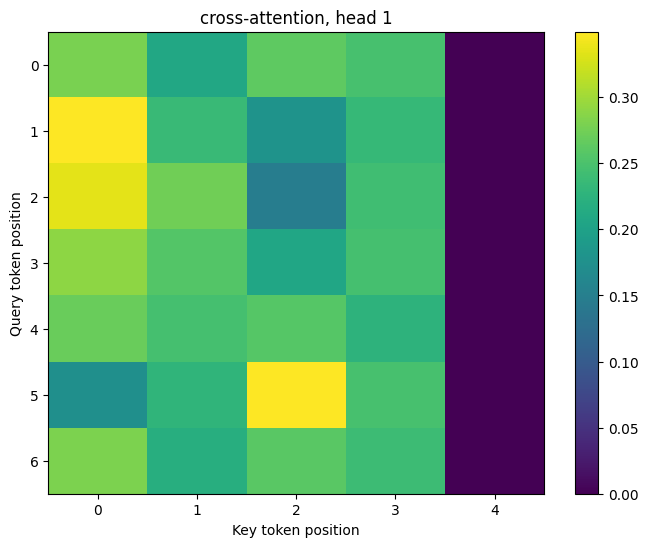

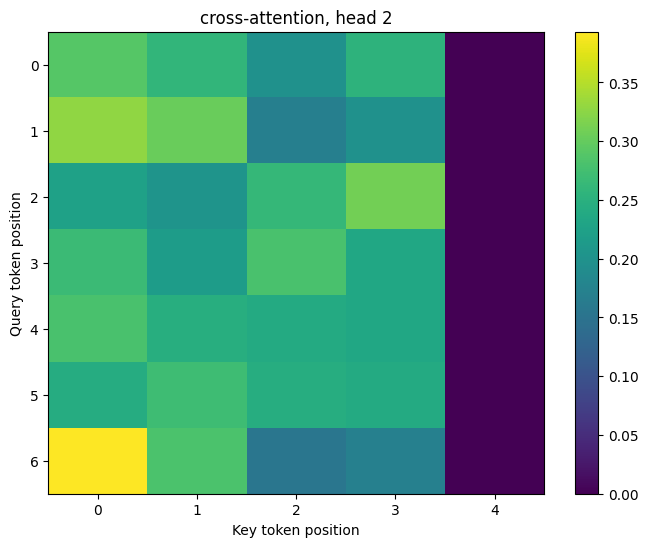

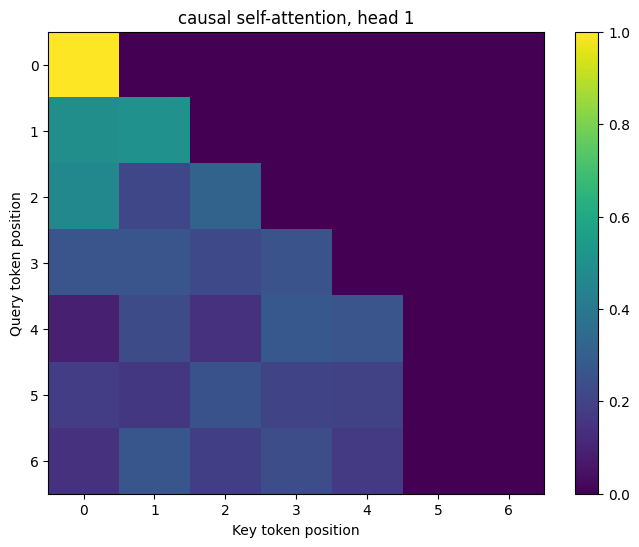

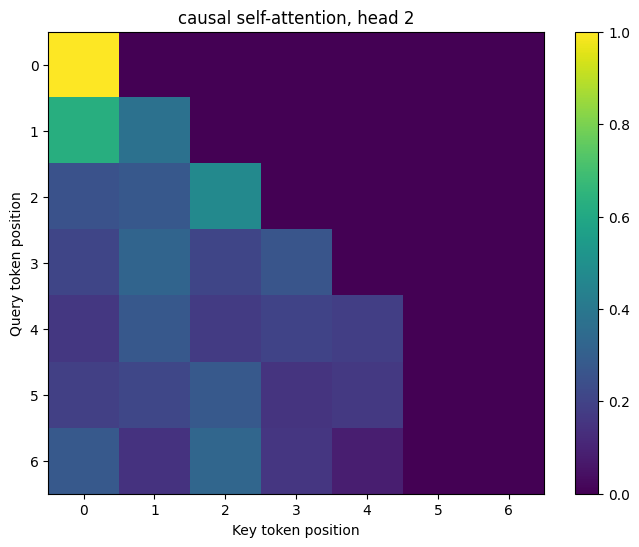

In [ ]:
embed_dim = 8
num_heads = 2
batch_size = 1
encoder_seq_length = 5
decoder_seq_length = 7

encoder_outputs = torch.randn(batch_size, encoder_seq_length, embed_dim)
decoder_inputs = torch.randn(batch_size, decoder_seq_length, embed_dim)

encoder_padding_mask = torch.zeros(batch_size, encoder_seq_length, dtype=torch.bool)
encoder_padding_mask[:, -1] = True # The last encoder token is a padding tokens

decoder_padding_mask = torch.zeros(batch_size, decoder_seq_length, dtype=torch.bool)
decoder_padding_mask[:, -2:] = True # The last two decoder tokens are padding token


cross_attention = MultiHeadAttention(embed_dim, num_heads, is_cross_attention=True)
causal_attention = MultiHeadAttention(embed_dim, num_heads, is_causal_attention=True)

cross_attention_out, cross_attention_weights = cross_attention(decoder_inputs, encoder_padding_mask, encoder_outputs)
causal_attention_out, causal_attention_weights = causal_attention(decoder_inputs, decoder_padding_mask)

# Make sure your outputs have the right hapes
assert cross_attention_out.shape == (batch_size, decoder_seq_length, embed_dim)
assert cross_attention_weights.shape == (batch_size, num_heads, decoder_seq_length, encoder_seq_length)
assert causal_attention_out.shape == (batch_size, decoder_seq_length, embed_dim)
assert causal_attention_weights.shape == (batch_size, num_heads, decoder_seq_length, decoder_seq_length)

# Check that the attention weights are normalized
assert torch.isclose(cross_attention_weights.sum(dim=-1), torch.tensor(1.0)).all()
assert torch.isclose(causal_attention_weights.sum(dim=-1), torch.tensor(1.0)).all()

# Check if the attention masking works
assert torch.isclose(cross_attention_weights[:,:,:,-1], torch.tensor(0.0)).all()
assert torch.isclose(causal_attention_weights[:,:,:,-2:], torch.tensor(0.0)).all()
assert torch.isclose(causal_attention_weights[:,:,2,3:], torch.tensor(0.0)).all()


import matplotlib.pyplot as plt

def plot_attention_matrix(attention_matrix, title):
    """Creates a new figure and plots the normalized attention weights as a heatmap.

    This should provide a colorbar for the scale of the heatmap and label the axes "query token position" and "key token position".
    Args:
        attention_matrix: A numpy array of shape (number_of_query_tokens, number_of_key_tokens)
        title: The title of the plot.
    """
    # TODO Implement this function
    plt.figure(figsize=(8, 6))
    plt.imshow(attention_matrix, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Key token position")
    plt.ylabel("Query token position")
    plt.show()



plot_attention_matrix(cross_attention_weights[0,0].detach().numpy(), "cross-attention, head 1")
plot_attention_matrix(cross_attention_weights[0,1].detach().numpy(), "cross-attention, head 2")
plot_attention_matrix(causal_attention_weights[0,0].detach().numpy(), "causal self-attention, head 1")
plot_attention_matrix(causal_attention_weights[0,1].detach().numpy(), "causal self-attention, head 2")

Embedding + positional embeddings

In this section, we implement the `TransformerEmbeddings` class, which combines token embeddings and positional embeddings to form the final embeddings used in a transformer model. This is a crucial step in preparing the input sequences for the transformer architecture. Here is a detailed explanation of the class and its components:

#### Class Initialization

1. **Token Embeddings**:
   - We use `nn.Embedding` to create an embedding matrix for the tokens. This matrix maps each token in the vocabulary to a dense vector of a specified `hidden_size`.
   - `vocab_size`: The size of the vocabulary determines the number of rows in the token embedding matrix.
   - `hidden_size`: The dimensionality of each embedding vector (the number of columns in the embedding matrix).

2. **Positional Embeddings**:
   - Transformers use positional embeddings to incorporate the order of tokens in the sequence since they do not inherently handle token positions.
   - `nn.Embedding` is also used to create an embedding matrix for positions, mapping each position in the sequence to a dense vector of the same `hidden_size`.
   - `max_sequence_length`: The maximum length of input sequences determines the number of rows in the positional embedding matrix.

3. **Maximum Sequence Length**:
   - We store the `max_sequence_length` to ensure that the positional embeddings can accommodate the longest possible input sequence.

#### Methods

1. **compute_logits**:
   - This method computes the logits for the next token prediction based on the decoder's output.
   - The decoder output, a tensor of shape `(batch_size, sequence_length, hidden_size)`, is multiplied by the transpose of the token embedding weights. This results in a tensor of shape `(batch_size, sequence_length, vocab_size)`, which contains the logits for each token in the vocabulary.

2. **forward**:
   - This method computes the embeddings for the input tokens by summing the token embeddings and positional embeddings.
   - `input_ids`: A tensor of shape `(batch_size, sequence_length)` containing the token IDs.
   - We create `position_ids`, a tensor of shape `(batch_size, sequence_length)`, where each position in the sequence is represented by its index (from 0 to `sequence_length - 1`).
   - Token embeddings are obtained by passing `input_ids` through the token embedding layer.
   - Positional embeddings are obtained by passing `position_ids` through the positional embedding layer.
   - The final embeddings are the sum of token embeddings and positional embeddings, resulting in a tensor of shape `(batch_size, sequence_length, hidden_size)`.

#### Example Workflow

1. **Initialization**:
   - The class is initialized with the vocabulary size, hidden size, and maximum sequence length.
   - Example: `TransformerEmbeddings(vocab_size=5000, hidden_size=512, max_sequence_length=100)`

2. **Forward Pass**:
   - Given input token IDs, the `forward` method generates token embeddings and positional embeddings.
   - It sums these embeddings to produce the final embeddings for the input sequence.

3. **Logit Computation**:
   - The `compute_logits` method takes the output from the decoder and computes the logits for the next token prediction using the token embedding weights.

This implementation ensures that each token in the input sequence is represented by a combination of its token embedding and its position in the sequence, enabling the transformer model to effectively process and understand the input data.

In [ ]:
class TransformerEmbeddings(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, max_sequence_length: int):
        """Defines the embedding layer with learnt positional embeddings.

        This layer defines both the token embeddings and positional embeddings,
        which are added together to form the final embedding.

        Args:
            vocab_size: The size of the vocabulary,
                    used to define the size of the token embedding table.
            hidden_size: The dimensionality of the embedding space for both token embeddings and positional embeddings.
            max_sequence_length: The maximum sequence length of the input sequences,
                    used to define the size of the position embedding table.

        Note that this implementation does not use dropout on the embeddings
        and uses learnt positional embeddings instead of sinusoidal embeddings.
        """
        super().__init__()

        # TODO Initialize the module and its parameters here.
        # You should use `nn.Embedding` for both token embeddings and positional embeddings
        # Initialize token and position embeddings

        self.token_embeddings = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings = nn.Embedding(max_sequence_length, hidden_size)

        # Store the maximum sequence length
        self.max_sequence_length = max_sequence_length

    def compute_logits(self, decoder_output: torch.FloatTensor) -> torch.FloatTensor:
        """Computes the logits for the next token prediction given the decoder output.

        Args:
            decoder_output: Tensor of shape (batch_size, sequence_length, hidden_size) - the output of the decoder.

        Returns:
            Tensor of shape (batch_size, sequence_length, vocab_size) containing the logits for the next token prediction.
        """

        # TODO Implement this function
        # Hint: you can access the weight parameter matrix via .weight of an nn.Embedding module:
        # Example:
        # ```embeddings = nn.Embedding(num_embeddings, embedding_dim)
        # assert list(embeddings.weight.shape) == [num_embeddings, embedding_dim]```
        # torch.matmul or F.linear may also be useful here.

        # Compute the logits using the token embedding weights
        logits = torch.matmul(decoder_output, self.token_embeddings.weight.T)
        return logits
    def forward(self, input_ids: torch.LongTensor) -> torch.FloatTensor:
        """Computes the embeddings for the input tokens.

        Args:
            input_ids: Tensor of shape (batch_size, sequence_length) containing the input token ids.

        Returns:
            Tensor of shape (batch_size, sequence_length, hidden_size) containing
                    the sum of token embeddings and position embeddings for the input tokens.
        """

        # TODO Implement the forward pass of the embedding layer.
        # IMPORTANT: For full credit, you should not use python loops!
        batch_size, sequence_length = input_ids.size()

        # Create position ids from 0 to sequence_length - 1
        position_ids = torch.arange(sequence_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand(batch_size, sequence_length)

        # Get token and position embeddings
        token_embeds = self.token_embeddings(input_ids)
        position_embeds = self.position_embeddings(position_ids)

        # Sum the token and position embeddings
        embeddings = token_embeds + position_embeds
        return embeddings


The `TransformerBlock` class represents a single block of the transformer architecture, which can be used for both the encoder and decoder parts of a transformer model. Here's a detailed breakdown of its components and functionality:

##### Class Initialization

1. **Self-Attention**:
   - The self-attention mechanism allows each token in the input sequence to attend to all other tokens. This is crucial for capturing dependencies regardless of their positions in the sequence.
   - We use the `MultiHeadAttention` class to implement self-attention.
   - If the block is part of the decoder (`is_decoder=True`), causal attention is applied to prevent a token from attending to future tokens.

2. **Add & Norm Layer**:
   - After the self-attention computation, we add the original input (residual connection) and apply layer normalization to stabilize and accelerate the training process.
   - `nn.LayerNorm` is used for this purpose.

3. **Cross-Attention (Decoder Only)**:
   - If the block is part of the decoder, it includes a cross-attention mechanism, which allows the decoder to attend to the encoder's outputs.
   - Another `MultiHeadAttention` layer is used for cross-attention, and a corresponding layer normalization is applied.

4. **Feedforward Layer**:
   - Each transformer block includes a feedforward neural network, which consists of two linear layers with a ReLU activation in between.
   - Dropout is applied after the second linear layer to prevent overfitting.
   - The feedforward network expands the dimensionality to `intermediate_size` and then projects it back to `hidden_size`.
   - The result is then normalized using another layer normalization.

##### Methods

1. **Forward Pass**:
   - This method defines the computations performed during the forward pass through the transformer block.

2. **Self-Attention and Residual Connection**:
   - The input `hidden_states` are passed through the self-attention layer.
   - The output is added to the original `hidden_states` (residual connection).
   - The result is then normalized using layer normalization.

3. **Cross-Attention and Residual Connection (Decoder Only)**:
   - If the block is a decoder block, the `hidden_states` are passed through the cross-attention layer, which attends to the encoder's outputs.
   - The output is added to the original `hidden_states` (residual connection).
   - The result is then normalized using layer normalization.

4. **Feedforward Network and Residual Connection**:
   - The `hidden_states` are passed through the feedforward network.
   - The output is added to the original `hidden_states` (residual connection).
   - The result is then normalized using layer normalization.

##### Example Workflow

1. **Initialization**:
   - The `TransformerBlock` is initialized with specific parameters like `hidden_size`, `intermediate_size`, `num_attention_heads`, `hidden_dropout_prob`, and whether it is a decoder block (`is_decoder`).

2. **Forward Pass**:
   - During the forward pass, the input `hidden_states` and `padding_mask` are processed through self-attention, optional cross-attention, and the feedforward network with residual connections and normalization applied at each step.

3. **Handling Encoder Outputs (Decoder Only)**:
   - For decoder blocks, `encoder_outputs` and `encoder_padding_mask` are used to facilitate cross-attention, allowing the decoder to utilize information from the encoder.

This implementation ensures that each token can effectively attend to relevant parts of the sequence, whether within the same layer (self-attention) or between encoder and decoder layers (cross-attention), while maintaining stable and efficient training through normalization and residual connections.

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 intermediate_size: int,
                 num_attention_heads: int,
                 hidden_dropout_prob: float,
                 is_decoder: bool = False):
        """Defines a single Transformer block, which can be either for the encoder or the decoder.

        Args:
            hidden_size: The dimensionality of the input and output vectors of this layer.
            intermediate_size: The intermediate size of the feedforward layers.
            num_attention_heads: The number of attention heads.
            hidden_dropout_prob: The dropout probability for the hidden states.
            is_decoder: Whether this block is part of the decoder.
        """
        super().__init__()

        self.is_decoder = is_decoder
        self.self_attention = MultiHeadAttention(hidden_size, num_attention_heads, is_causal_attention=is_decoder)
        #add&norm layer
        self.self_attention_layer_norm = nn.LayerNorm(hidden_size)

#if decoder use cross attention
        if is_decoder:
            self.cross_attention = MultiHeadAttention(hidden_size, num_attention_heads, is_cross_attention=True)
            self.cross_attention_layer_norm = nn.LayerNorm(hidden_size)
#feedForward layer
        self.feedforward = nn.Sequential(
            nn.Linear(hidden_size, intermediate_size),
            nn.ReLU(),
            nn.Linear(intermediate_size, hidden_size),
            nn.Dropout(hidden_dropout_prob))
        self.feedforward_layer_norm = nn.LayerNorm(hidden_size)

    def forward(self,
                hidden_states: torch.FloatTensor,
                padding_mask: torch.BoolTensor,
                encoder_outputs: Optional[torch.FloatTensor] = None,
                encoder_padding_mask: Optional[torch.BoolTensor] = None) -> torch.FloatTensor:
        """Defines a single Transformer block, either for the encoder or the decoder.

        Args:
            hidden_states: Tensor of shape (batch_size, sequence_length, hidden_size) - the outputs from the previous layer.
            padding_mask: Tensor of shape (batch_size, sequence_length) indicating which tokens are padding tokens.
                    A `True` entry means that this token should be ignored for the purpose of attention.
            encoder_outputs: Optional tensor of shape (batch_size, encoder_sequence_length, hidden_size),
                    which are the output vectors of the encoder. This argument is only used by decoder blocks.
            encoder_padding_mask: Optional tensor of shape (batch_size, encoder_sequence_length) indicating
                    which encoder tokens are padding tokens. This argument is only used in decoder blocks.
                    A `True` entry means that this token should be ignored for the purpose of attention.

        """
        hidden_states = self.self_attention(hidden_states, padding_mask)[0] + hidden_states
        hidden_states = self.self_attention_layer_norm(hidden_states)

        if self.is_decoder:
            hidden_states = self.cross_attention(hidden_states, encoder_padding_mask, encoder_outputs)[0] + hidden_states
            hidden_states = self.cross_attention_layer_norm(hidden_states)

        hidden_states = self.feedforward(hidden_states) + hidden_states
        hidden_states = self.feedforward_layer_norm(hidden_states)
        return hidden_states

#### EncoderDecoderModel Class Summary

The `EncoderDecoderModel` class implements an encoder-decoder transformer model for neural machine translation (NMT). It consists of the following components:

- **Initialization (`__init__` method):**
  - **Source and Target Embeddings:** Utilizes `TransformerEmbeddings` to create embeddings for the source and target vocabularies.
  - **Encoder Blocks:** A list of encoder blocks (`TransformerBlock`), initialized based on `num_encoder_layers`.
  - **Decoder Blocks:** A list of decoder blocks (`TransformerBlock` with `is_decoder=True`), initialized based on `num_decoder_layers`.
  - **Output Projection Layer:** A linear layer projecting hidden states to target vocabulary size.

- **Encoder Forward Pass (`forward_encoder` method):**
  - Computes embeddings for the source input IDs.
  - Passes these embeddings through the encoder blocks.
  - Returns the final hidden states of the encoder.

- **Decoder Forward Pass (`forward_decoder` method):**
  - Computes embeddings for the target input IDs.
  - Passes these embeddings through the decoder blocks, utilizing cross-attention with encoder outputs.
  - Projects the hidden states to produce logits for the target vocabulary.
  - Returns the final logits for next token prediction.

- **Full Model Forward Pass (`forward` method):**
  - Combines the encoder and decoder forward passes.
  - Processes input sequences and produces output logits for the target sequence.

This class encapsulates the entire transformer model workflow, handling embedding lookups, multi-head attention, and the necessary transformations to generate translations.

In [ ]:
class EncoderDecoderModel(nn.Module):
    def __init__(self,
                 source_vocab_size: int,
                 target_vocab_size: int,
                 hidden_size: int,
                 intermediate_size: int,
                 num_attention_heads: int,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 max_sequence_length: int,
                 hidden_dropout_prob: float):
        """A encoder-decoder transformer model which can be used for NMT.

        Args:
            source_vocab_size: The size of the source vocabulary.
            target_vocab_size: The size of the target vocabulary.
            hidden_size: The dimensionality of all input and output embeddings.
            intermediate_size: The intermediate size in the feedforward layers.
            num_attention_heads: The number of attention heads in each multi-head attention modules.
            num_encoder_layers: The number of transformer blocks in the encoder.
            num_decoder_layers: The number of transformer blocks in the decoder.
            max_sequence_length: The maximum sequence length that this model can handle.
            hidden_dropout_prob: The dropout probability in the hidden state in each block.
        """

        super().__init__()
        # TODO Register the input embedding modules and the encoder and decoder blocks.
        # You should use the TransformerBlock and TransformerEmbeddings sub-modules.
        #
        # Hint: Check out `nn.ModuleList` to register a variable number of sub-modules.
        # Define input embeddings for source and target tokens
        self.source_embeddings = TransformerEmbeddings(source_vocab_size, hidden_size, max_sequence_length) #for enocder
        self.target_embeddings = TransformerEmbeddings(target_vocab_size, hidden_size, max_sequence_length) #for decoder

        # Define encoder blocks
        self.encoder = nn.ModuleList([
            TransformerBlock(hidden_size, intermediate_size, num_attention_heads, hidden_dropout_prob)
            for _ in range(num_encoder_layers)
        ])

        # Define decoder blocks
        self.decoder = nn.ModuleList([
            TransformerBlock(hidden_size, intermediate_size, num_attention_heads, hidden_dropout_prob, is_decoder=True)
            for _ in range(num_decoder_layers)
        ])

        # Define output projection layer
        self.output_projection = nn.Linear(hidden_size, target_vocab_size)

    def forward_encoder(self, input_ids: torch.LongTensor, padding_mask: torch.BoolTensor) -> torch.FloatTensor:
        """Implement the forward pass of the encoder.

        Args:
            input_ids: tensor of shape (batch_size, sequence_length) containing the input token ids to the encoder.
            padding_mask: tensor of shape (batch_size, sequence_length) indicating which encoder tokens are padding tokens (`True`)
                    and should be ignored in self-attention computations.

        Returns:
            Tensor of shape (batch_size, sequence_length, hidden_size) containing the output embeddings of the encoder.
        """

        # TODO Implement this function
        # Get source token embeddings
        source_embeddings = self.source_embeddings(input_ids)

        # Forward pass through encoder blocks
        encoder_hidden_states = source_embeddings
        for encoder_block in self.encoder:
            encoder_hidden_states = encoder_block(encoder_hidden_states, padding_mask)

        return encoder_hidden_states

    def forward_decoder(self,
                        input_ids: torch.LongTensor,
                        padding_mask: torch.BoolTensor,
                        encoder_outputs: torch.FloatTensor,
                        encoder_padding_mask: torch.BoolTensor) -> torch.FloatTensor:
        """Implement the forward pass of the decoder.

        Args:
            input_ids: Tensor of shape (batch_size, sequence_length) containing the input token ids to the decoder.
            padding_mask: Tensor of shape (batch_size, sequence_length) indicating which decoder tokens are padding tokens (`True`)
                    and should be ignored in self-attention computations.
            encoder_outputs: Tensor of shape (batch_size, encoder_sequence_length, hidden_size) containing the output embeddings of the encoder.
            encoder_padding_mask: Tensor of shape (batch_size, encoder_sequence_length) indicating which encoder tokens are padding tokens (`True`)
                    and should be ignored in cross-attention computations.

        Returns:
            Tensor of shape (batch_size, sequence_length, target_vocabulary_size)
            containing the logits for predicting the next token in the target sequence.
        """

        # TODO Implement this function

        # Get target token embeddings
        target_embeddings = self.target_embeddings(input_ids)

        # Forward pass through decoder blocks
        decoder_hidden_states = target_embeddings
        for decoder_block in self.decoder:
            decoder_hidden_states = decoder_block(decoder_hidden_states, padding_mask, encoder_outputs, encoder_padding_mask)

        # Project to target vocabulary size
        decoder_logits = self.output_projection(decoder_hidden_states)

        return decoder_logits

    def forward(self, encoder_input_ids, encoder_padding_mask, decoder_input_ids, decoder_padding_mask):
        encoder_outputs = self.forward_encoder(encoder_input_ids, encoder_padding_mask)
        decoder_logits = self.forward_decoder(decoder_input_ids, decoder_padding_mask, encoder_outputs, encoder_padding_mask)
        return decoder_logits

## Train the model

In this section, we train the seq2seq model on the parallel tokenized corpus.
Before you start training models, you should implement and test the model and its sub-modules, especially the attention.

First, we implement a `collate` function, which takes a list of examples from the dataset and forms a batch,
consisting of padded encoder and decoder input ids, as well as encoder and decoder padding masks.



The `collate_fn` function prepares a batch of variable-length sequences for neural network training by standardizing their lengths. It determines the longest sequence in the batch and initializes tensors filled with a padding token to match this length. It then populates these tensors with the actual sequence data and creates corresponding padding masks to indicate real tokens versus padding tokens. This process ensures uniform input shapes for efficient batch processing, allows the model to ignore padding during computations, and is especially critical for models using attention mechanisms to handle sequences correctly.

In [ ]:
def collate_fn(examples: List[Dict[str, List[int]]]) -> Dict[str, torch.Tensor]:
    """Collates a list of variable length sequences from the dataset into a batch of pytorch tensors with padding."""

    # Determine the maximum sequence lengths for the encoder and decoder inputs in the batch
    encoder_sequence_length = max(len(example["encoder_input_ids"]) for example in examples)
    decoder_sequence_length = max(len(example["decoder_input_ids"]) for example in examples)
    batch_size = len(examples)

    # Initialize tensors for encoder input IDs and padding mask with the appropriate sizes
    # Fill encoder_input_ids with the pad token ID and encoder_padding_mask with True (indicating padding)
    encoder_input_ids = torch.full((batch_size, encoder_sequence_length),
                                   fill_value=source_tokenizer.pad_token_id,
                                   dtype=torch.int64)
    encoder_padding_mask = torch.ones((batch_size, encoder_sequence_length),
                                      dtype=torch.bool)

    # Initialize tensors for decoder input IDs and padding mask with the appropriate sizes
    # Fill decoder_input_ids with the pad token ID and decoder_padding_mask with True (indicating padding)
    decoder_input_ids = torch.full((batch_size, decoder_sequence_length),
                                   fill_value=target_tokenizer.pad_token_id,
                                   dtype=torch.int64)
    decoder_padding_mask = torch.ones((batch_size, decoder_sequence_length),
                                      dtype=torch.bool)

    # Fill the initialized tensors with actual input IDs and update padding masks
    for i, example in enumerate(examples):
        # Copy encoder input IDs to the tensor and set corresponding padding mask entries to False
        encoder_input_ids[i, :len(example["encoder_input_ids"])] = torch.tensor(example["encoder_input_ids"])
        encoder_padding_mask[i, :len(example["encoder_input_ids"])] = False

        # Copy decoder input IDs to the tensor and set corresponding padding mask entries to False
        decoder_input_ids[i, :len(example["decoder_input_ids"])] = torch.tensor(example["decoder_input_ids"])
        decoder_padding_mask[i, :len(example["decoder_input_ids"])] = False

    # Return the collated batch as a dictionary of tensors
    return {"encoder_input_ids": encoder_input_ids,
            "encoder_padding_mask": encoder_padding_mask,
            "decoder_input_ids": decoder_input_ids,
            "decoder_padding_mask": decoder_padding_mask}


Next, we provide a simple training loop.

In [ ]:
import time
import math

#compute the los using cross Entropy
def compute_loss_per_token(model, batch):
    logits = model(**batch)

    valid_label_mask = ~(batch["decoder_padding_mask"][:,1:])
    labels = batch["decoder_input_ids"][:,1:][valid_label_mask]
    logits = logits[:,:-1][valid_label_mask]

    return F.cross_entropy(logits, labels, reduction='none')


def evaluate_perplexity(model, dataset, batch_size=32, device="cpu"):
    model.eval()

    dev_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    num_tokens = loss_sum = 0

    # no_grad() signals backend to throw away all gradients
    with torch.no_grad():
        for batch in dev_loader:
            # Move tensors in batch to device
            for key in batch:
                batch[key] = batch[key].to(device)

            token_losses = compute_loss_per_token(model, batch)

            loss_sum += token_losses.sum()
            num_tokens += token_losses.numel()

        dev_ppl = (loss_sum / num_tokens).exp().cpu().item()
    return dev_ppl


def train(model, training_dataset, validation_dataset,
          batch_size=32, lr=1e-3, max_epoch=10, log_every=10, valid_niter=100,
          model_path="model.pt"):
    model.train()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('Use device: %s' % device)

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    epoch = global_step = loss_sum = num_tokens = num_examples = 0
    best_valid_perplexity = float('inf')
    train_time = begin_time = time.time()
    print('Beginning maximum likelihood training')


    while True:
        train_loader = torch.utils.data.DataLoader(
            training_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        epoch += 1
        batches_per_epoch = len(train_loader)
        for i, batch in enumerate(train_loader):
            global_step += 1

            # Move tensors in batch to device
            for key in batch:
                batch[key] = batch[key].to(device)
#optimizer.zero_grad() ensures that the gradients are cleared before computing the new gradients reset the gradient
            optimizer.zero_grad()

            token_losses = compute_loss_per_token(model, batch)
            total_loss = token_losses.sum()

            loss = total_loss / batch_size

#loss.backward() computes the gradients of the loss with respect to the model parameters.
            loss.backward()

#optimizer.step() updates the model parameters based on the computed gradients.

            optimizer.step()

            loss_sum += total_loss.cpu().item()
            num_tokens += token_losses.numel()
            num_examples += batch_size

            if global_step % log_every == 0:
                average_loss = loss_sum / num_examples
                average_ppl = math.exp(loss_sum / num_tokens)
                print(f"epoch {epoch} ({i}/{batches_per_epoch}) | step {global_step} | "
                      f"avg_nll={average_loss:.2f} avg_ppl={average_ppl:.2f} "
                      f"speed={num_tokens / (time.time() - train_time):.2f} words/sec "
                      f"time_elapsed={time.time() - begin_time:.2f} sec")

                train_time = time.time()
                loss_sum = num_tokens = num_examples = 0.0

            if global_step % valid_niter == 0:
                print('Begin validation ...')
                dev_perplexity = evaluate_perplexity(model, validation_dataset, batch_size=batch_size, device=device)

                print(f"validation: step {global_step} | dev_ppl={dev_perplexity}")

                if dev_perplexity < best_valid_perplexity:
                    best_valid_perplexity = dev_perplexity
                    print(f"epoch {epoch} step {global_step}: save currently the best model to '{model_path}'")
                    torch.save(model.state_dict(), model_path)
                    torch.save(optimizer.state_dict(), model_path + '.optim')
                model.train()

        if epoch == max_epoch:
            print('Reached maximum number of epochs')
            break

Let's train a relatively small model architecture for 15 epochs.
With a reasonable implementation, this should take about 16 minutes on CPU / 3 minutes on GPU and we should achieve a validation perplexity of below 10!

In [ ]:
# Set a random seed, so you obtain the same output model if you run this cell again.
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

model = EncoderDecoderModel(
    source_vocab_size=source_tokenizer.vocab_size,
    target_vocab_size=target_tokenizer.vocab_size,
    hidden_size=32,
    intermediate_size=32 * 4,
    num_attention_heads=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    max_sequence_length=32,
    hidden_dropout_prob=0.1,
    )

print("Model architecture:", model)
print("Total number of trainable model parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

train(model, tokenized_datasets["train"], tokenized_datasets["validation"],
      max_epoch=15, model_path="model.pt")

Model architecture: EncoderDecoderModel(
  (source_embeddings): TransformerEmbeddings(
    (token_embeddings): Embedding(3200, 32)
    (position_embeddings): Embedding(32, 32)
  )
  (target_embeddings): TransformerEmbeddings(
    (token_embeddings): Embedding(3200, 32)
    (position_embeddings): Embedding(32, 32)
  )
  (encoder): ModuleList(
    (0-2): 3 x TransformerBlock(
      (self_attention): MultiHeadAttention(
        (query_proj): Linear(in_features=32, out_features=32, bias=True)
        (key_proj): Linear(in_features=32, out_features=32, bias=True)
        (value_proj): Linear(in_features=32, out_features=32, bias=True)
        (out_proj): Linear(in_features=32, out_features=32, bias=True)
      )
      (self_attention_layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (feedforward): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=32, bias=True)
        (3):

## Evaluate the model

We have trained a seq2seq model for the NMT task. Now let's evaluate the model on the test set by generating translations with beam search and comparing them to the gold translations using the BLEU score.

In [ ]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

def beam_search(model: EncoderDecoderModel,
                encoder_input_ids: torch.LongTensor,
                beam_width: int = 5,
                max_len: int = 32) -> Tuple[torch.LongTensor, float]:
    """Run beam search on the encoder-decoder model for a single source sequence.

    Args:
        model: The encoder-decoder model.
        encoder_input_ids: The input sequence. Tensor of shape [encoder_sequence_length].
        beam_width: Number of generations to expand at each time step.
        max_len: Stop generation when reaching this length for the generated sequence.

    Returns:
        A tuple (generation, score) where generation is the generated target sequence and
            a tensor of shape [target_sequence_length] and score is the corresponding
            log-probability of this generation.
    """
    model.eval()

    encoder_input_ids = encoder_input_ids.unsqueeze(0) # Add the batch dimension
    encoder_padding_mask = torch.zeros_like(encoder_input_ids, dtype=torch.bool) # No padding
    encoder_outputs = model.forward_encoder(encoder_input_ids, encoder_padding_mask)

    generations = [torch.tensor([target_tokenizer.bos_token_id], device=encoder_input_ids.device)]
    scores = [0.0]

    best_generation = None
    best_score = float('-inf')

    for _ in range(max_len):
        new_generations = []
        new_scores = []
        for score, generation in zip(scores, generations):
            generation = generation.unsqueeze(0) # Add the batch dimension
            padding_mask = torch.zeros_like(generation, dtype=torch.bool) # No padding
            decoder_output = model.forward_decoder(generation, padding_mask, encoder_outputs, encoder_padding_mask)
            last_log_probs = decoder_output[0, -1, :].log_softmax(dim=-1)
            top_log_probs, top_indices = last_log_probs.topk(beam_width, dim=-1)

            new_generations.append(torch.cat([generation.expand(beam_width, -1), top_indices[:,None]], dim=1))
            new_scores.append(score + top_log_probs)

        new_generations = torch.cat(new_generations, dim=0)
        new_scores = torch.cat(new_scores, dim=0)

        ends_with_eos = target_tokenizer.eos_token_id == new_generations[:,-1]

        if ends_with_eos.any():
            new_completed_generations = new_generations[ends_with_eos]
            new_completed_scores = new_scores[ends_with_eos]

            if new_completed_scores.max() > best_score:
                best_score = new_completed_scores.max()
                best_generation = new_completed_generations[new_completed_scores.argmax()]

        if best_score >= new_scores.max():
            break

        scores, indices = torch.topk(new_scores, beam_width, dim=-1)
        generations = new_generations[indices]

    if best_generation is None:
        best_generation = generations[0]
        best_score = scores[0]

    return best_generation, best_score.cpu().item()


def run_generation(model, test_dataset, beam_size=5, max_decoding_time_step=32):
    """Run beam search decoding on the test set, compute BLEU and return reference and candidate target sentences.
    """

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Use device: %s' % device)

    input_sentences = []
    reference_sentences = []
    candidate_sentences = []

    with torch.no_grad():
        for example in tqdm(test_dataset):
            encoder_input_ids = torch.tensor(example["encoder_input_ids"], device=device)

            generation, _ = beam_search(model, encoder_input_ids, beam_size, max_decoding_time_step)

            # Decode given source sequence and generated target sequence and avoid special tokens

            input_text = "".join(source_tokenizer.decode(token).replace("▁", " ") for token in example["encoder_input_ids"][1:-1])
            reference_text = "".join(target_tokenizer.decode(token).replace("▁", " ") for token in example["decoder_input_ids"][1:-1])
            candidate_text = "".join(target_tokenizer.decode(token).replace("▁", " ") for token in generation[1:-1].cpu())

            reference_sentences.append(reference_text)
            candidate_sentences.append(candidate_text)
            input_sentences.append(input_text)


    bleu_score = corpus_bleu([[ref] for ref in reference_sentences],
                             [candidate for candidate in candidate_sentences])

    return bleu_score, input_sentences, reference_sentences, candidate_sentences

In [ ]:
# Restore the best validation checkpoint
model.load_state_dict(torch.load("model.pt"))

bleu_score, inputs, references, candidates = run_generation(model, tokenized_datasets["test"])
print('\n\nCorpus BLEU: {}'.format(bleu_score * 100))

Use device: cpu


100%|██████████| 486/486 [01:08<00:00,  7.13it/s]




Corpus BLEU: 56.50580595062262


Let's look at some examples. What do you think of the quality of the translations?

In [ ]:
# Feel free to change the range to look at more samples!
for k in range(10, 20):
  print(f"===== Sample {k} =====")
  print(f"Input: {inputs[k]}")
  print(f"Gold: {references[k]}")
  print(f"Pred: {candidates[k]}")

===== Sample 10 =====
Input:  vous me mettez mal a l aise .
Gold:  you re embarrassing me .
Pred:  you re embarrassing me .
===== Sample 11 =====
Input:  c est toi le professeur .
Gold:  you re the teacher .
Pred:  you re the teacher .
===== Sample 12 =====
Input:  elle sourit avec bonheur .
Gold:  she smiled happily .
Pred:  she stared at up with him .
===== Sample 13 =====
Input:  je ne suis pas devin .
Gold:  i m not a psychic .
Pred:  i m not married .
===== Sample 14 =====
Input:  vous allez perdre .
Gold:  you re going to lose .
Pred:  you re going back .
===== Sample 15 =====
Input:  vous me touchez .
Gold:  you re touching me .
Pred:  you re embarrassing me .
===== Sample 16 =====
Input:  je pars aujourd hui .
Gold:  i m leaving today .
Pred:  i m going .
===== Sample 17 =====
Input:  je ne suis pas une sainte .
Gold:  i m no saint .
Pred:  i m not a student .
===== Sample 18 =====
Input:  je suis puissant .
Gold:  i m powerful .
Pred:  i m retired .
===== Sample 19 =====
Input

# Questions

Please answer written questions from the assignment in this section. You can alter the provided code to obtain the answers, but be careful not to break anything!

**(b) (4 points)**

- (i)
    What vocabulary size are we using for the source and target language?

- (ii)
    Approximately how many source and target tokens are on average contained in a training batch? What proportion of these tokens are `<pad>` tokens on average?

- (iii)
What is the specific purpose of saving the model parameters in a file `model.pt` throughout training in the code we provide?

**(c) (2 points)**
Manually look at some results and compare them with the gold answers. What do you think of the quality of the translations? Are these grammatical English sentences? Can you identify any common mistakes?

**(d) (4 points)**
Consider the provided beam search method. This implementation is not efficient and performs a lot of repeated computation. Identify the issue and propose how you can fix it.
In particular, describe how would you have to change the arguments and return values of your EncoderDecoderModel and its sub-modules?

**B) i-vocab size:** >> 3200 (token_embeddings): Embedding(3200, 32)

**ii- padding:** >> This suggests that approximately 1500 words are processed per second.

However, the exact batch size isn't directly stated. Assuming a typical setting for a Transformer model, a common batch size might be 64 sentences with an average length of 20 tokens each, resulting in 1280 tokens per batch.

As for the proportion of <pad> tokens, it's often observed in practice that padding can make up about 20-30% of tokens in a batch, especially in batches with variable-length sequences.

**iii-purpose of the model:** >>The model parameters are saved to model.pt to retain the best performing model during training. This is done to ensure that the model with the lowest validation perplexity (ppl) is preserved, which is useful for later evaluation or deployment.






**C)** Quality of Translations

**Grammaticality of Sentences:**
Most of the predicted sentences are grammatically correct English sentences. However, there are some sentences where the meaning significantly deviates from the gold standard, even though they are still grammatically correct.

**Common Mistakes:**
1. **Semantic Deviations:**
   - **Sample 12:** "she smiled happily" vs. "she stared at up with him". The prediction changes the verb and adds unnecessary words, altering the original meaning.
   - **Sample 13:** "i m not a psychic" vs. "i m not married". Here, the model completely changes the predicate, leading to a loss of the intended meaning.
   - **Sample 14:** "you re going to lose" vs. "you re going back". The predicted sentence is grammatically correct but changes the meaning from "losing" to "going back".

2. **Incorrect Subject or Object:**
   - **Sample 15:** "you re touching me" vs. "you re embarrassing me". The subject remains the same, but the action is incorrectly predicted.
   - **Sample 16:** "i m leaving today" vs. "i m going". The prediction omits important temporal information ("today").

3. **Contextual Errors:**
   - **Sample 17:** "i m no saint" vs. "i m not a student". Here, the prediction changes the noun, which alters the contextual meaning.
   - **Sample 18:** "i m powerful" vs. "i m retired". The model misinterprets the adjective, leading to a different statement about the speaker.

**Overall Analysis:**
While the model performs well on simple and direct sentences (Samples 10, 11, 19), it struggles with more nuanced translations where context or specific vocabulary is crucial. The sentences generated are generally grammatical, but they often miss the precise meaning conveyed by the gold standard translations. The most common mistakes involve altering key verbs, misinterpreting nouns, and omitting important context-specific details.

**D)**
To address the inefficiency in the provided beam search method, we need to ensure that the encoder's output is computed only once and then reused across all beams.

To achieve this, the encoder should produce its output once, which will be fed into the decoder multiple times during the beam search.

Additionally, the encoder must return all necessary intermediate values (such as hidden states) needed for decoding.

The decoder should then be adjusted to accept these precomputed encoder outputs as input, along with the current state and inputs from the decoder.

By doing this, we eliminate redundant computations and significantly improve the efficiency of the beam search process.